# Binning Data for Report 2

Testing code that allows us to find a 3 day moving average of daily average temperatures and comparing a daily average temperature to the average daily temperatures for the 3 previous days.

In [1]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot_date
import seaborn as sns

import datetime as dt
from datetime import datetime
from IPython.display import display

import thinkstats2
import thinkplot

import statsmodels.formula.api as smf

In [2]:
stations = {'seattle': 'WBAN:24233', 
            'boston': 'WBAN:14739', 
            'lexington': 'WBAN:93820', 
            'san diego': 'WBAN:93107'}

# Make a date parsing function with the correct format
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M')

# Read the CSV while parsing the dates
df = pd.read_csv("913023.csv", parse_dates=['DATE'], date_parser=dateparse)

/home/william/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,8,10,11,12,13,14,15,16,17,19,20,22,23,25,26,27,28,29,33,34,37,38,39,40,44,45,46,47,48,50,59,60,62,63,64,67,68,69,71,72,73,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Remove all columns except for STATION, DATE, DAILYAverageDryBulbTemp, DAILYPrecip
#Make a copy of the original DataFrame
seatac = df.copy(deep=True)

#Uses DATE column as row index for resampling purposes later
seatac.set_index('DATE', inplace=True)

#Select rows of data for Seattle (WBAN:24233)
seatac = seatac.loc[seatac['STATION'] == stations['seattle']]

#Select columns with data we need
seatac = seatac[['STATION', 'DAILYAverageDryBulbTemp', 'DAILYPrecip']]

#Select 2015 data
seatac_2015 = seatac.copy(deep=True)
seatac_2015 = seatac_2015.ix['2015-01-01':'2015-12-31']
# display(seatac_2015)

In [4]:
# Turn all non-numerical values into NaN for columns that should be numbers (via coerce) 
seatac_2015['DAILYAverageDryBulbTemp'] = seatac_2015['DAILYAverageDryBulbTemp'].apply(pd.to_numeric, errors='coerce')
seatac_2015['DAILYPrecip'] = seatac_2015['DAILYPrecip'].apply(pd.to_numeric, errors='coerce')

#Drop rows where there is no DAILYAverageDryBulbTemp value
seatac_2015.dropna(subset=['DAILYAverageDryBulbTemp'], inplace=True)

# Replace NaN for precipitation with 0
seatac_2015['DAILYPrecip'].fillna(0, inplace=True)

# Replace trace amounts of precipitation ('T') with 0
seatac_2015['DAILYPrecip'].replace('T', 0, inplace=True)

# Downsamples data to 1 day -- temperatures are averaged and precipitation is added
seatac_2015 = seatac_2015.resample('1D').agg({'DAILYAverageDryBulbTemp': np.mean, 'DAILYPrecip': np.sum})

# Fills in upsampled data that is NaN with data from previous day
seatac_2015.DAILYAverageDryBulbTemp.fillna(method='pad', limit=2,inplace=True)
seatac_2015.DAILYPrecip.fillna(method='pad', inplace=True)

# display(seatac_2015)

In [5]:
# Takes the 3 day moving average of temperature
seatac_2015['MOVAvg'] = seatac_2015.rolling(window='3D', min_periods=1).mean()['DAILYAverageDryBulbTemp']

# display(seatac_2015)

In [6]:
# Calculates deviation from the moving average for the previous three days of temperature data
for d in seatac_2015.index:
    if d.month == 1 and d.day == 1:
        seatac_2015.loc[d, 'DEVFromAvg'] = 0
    else:
        seatac_2015.loc[d, 'DEVFromAvg'] = seatac_2015.loc[d, 'DAILYAverageDryBulbTemp'] - seatac_2015.loc[d-1, 'MOVAvg']

# display(seatac_2015)

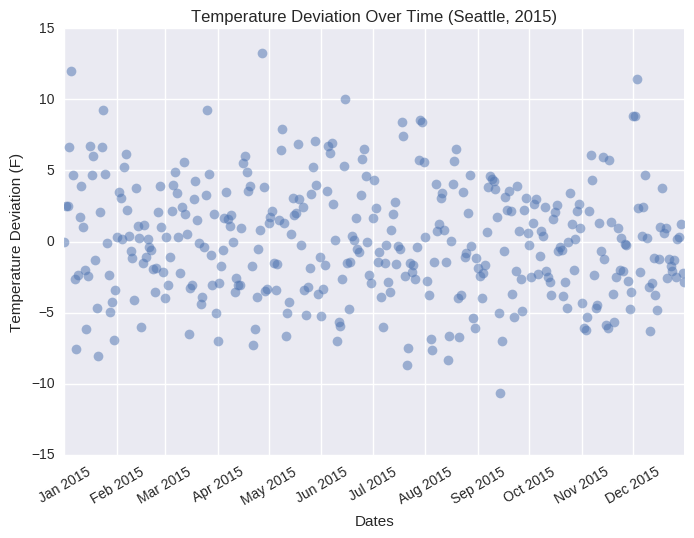

In [7]:
# Graph scatterplot of temperature deviations over time
temp_deviation = seatac_2015.copy(deep=True)
temp_deviation = temp_deviation['DEVFromAvg']

plot_date(seatac_2015.index.astype(datetime), seatac_2015.DEVFromAvg, alpha=0.5)
plt.xticks(rotation=30)
plt.xlabel('Dates')
plt.ylabel('Temperature Deviation (F)')
plt.title('Temperature Deviation Over Time (Seattle, 2015)')
plt.show()

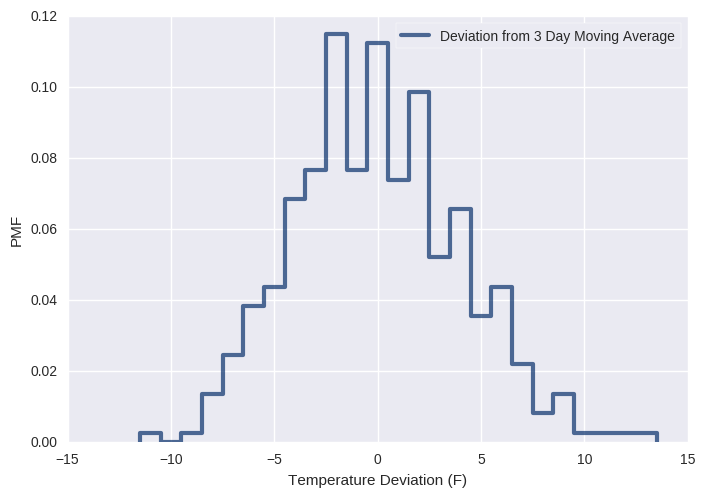

In [8]:
# Plot PMF of temperature deviations
all_temp_dev_pmf = thinkstats2.Pmf(temp_deviation.round(decimals=0), label='Deviation from 3 Day Moving Average')
thinkplot.Pmf(all_temp_dev_pmf)
thinkplot.Config(xlabel='Temperature Deviation (F)', ylabel='PMF')
thinkplot.Show()

In [9]:
# Evaluates whether or not precipitation occurred on a day
seatac_2015['BOOLPrecip'] = seatac_2015.DAILYPrecip > 0
seatac_2015['BOOLPrecipNum'] = seatac_2015['BOOLPrecip'].astype(int)

display(seatac_2015)

,DAILYPrecip,DAILYAverageDryBulbTemp,MOVAvg,DEVFromAvg,BOOLPrecip,BOOLPrecipNum
DATE,,,,,,
2015-01-01,0.00,34.250000,34.250000,0.000000,False,0
2015-01-02,0.06,36.750000,35.500000,2.500000,True,1
2015-01-03,0.06,38.000000,36.333333,2.500000,True,1
2015-01-04,0.40,43.000000,39.250000,6.666667,True,1
2015-01-05,0.70,51.250000,44.083333,12.000000,True,1
2015-01-06,0.24,48.750000,47.666667,4.666667,True,1
2015-01-07,0.00,45.000000,48.333333,-2.666667,False,0
2015-01-08,0.00,40.750000,44.833333,-7.583333,False,0
2015-01-09,0.01,42.500000,42.750000,-2.333333,True,1


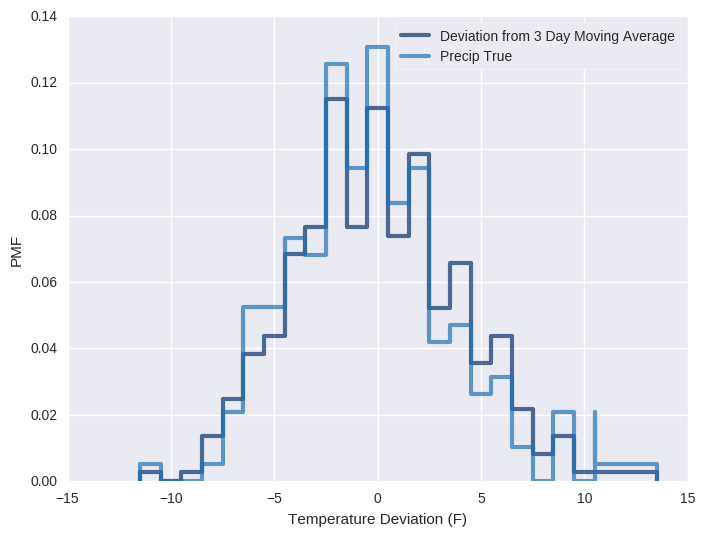

In [10]:
# Plots PMFs of all temperature deviation and temperature deviation when there is precipitation for comparison

seatac_2015_precip_true = seatac_2015[seatac_2015.BOOLPrecip == True].copy(deep=True)
precip_temp_dev_pmf = thinkstats2.Pmf(seatac_2015_precip_true['DEVFromAvg'].round(decimals=0), label='Precip True')

thinkplot.Pmf(all_temp_dev_pmf)
thinkplot.Pmf(precip_temp_dev_pmf)
thinkplot.Config(xlabel='Temperature Deviation (F)', ylabel='PMF')
thinkplot.Show()

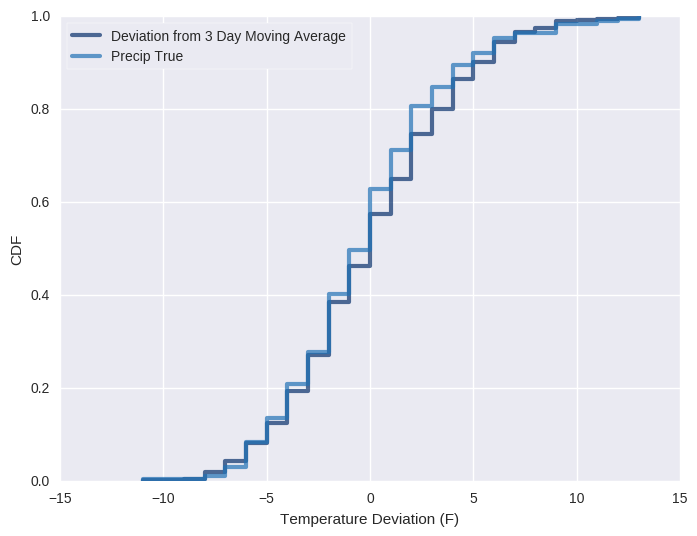

In [11]:
# Plots CDFs of all temperature deviation and temperature deviation when there is precipitation for comparison

all_temp_dev_cdf = thinkstats2.Cdf(temp_deviation.round(decimals=0), label='Deviation from 3 Day Moving Average')
precip_temp_dev_cdf = thinkstats2.Cdf(seatac_2015_precip_true['DEVFromAvg'].round(decimals=0), label='Precip True')

thinkplot.Cdf(all_temp_dev_cdf)
thinkplot.Cdf(precip_temp_dev_cdf)
thinkplot.Config(xlabel='Temperature Deviation (F)', ylabel='CDF', loc='best')
thinkplot.Show()

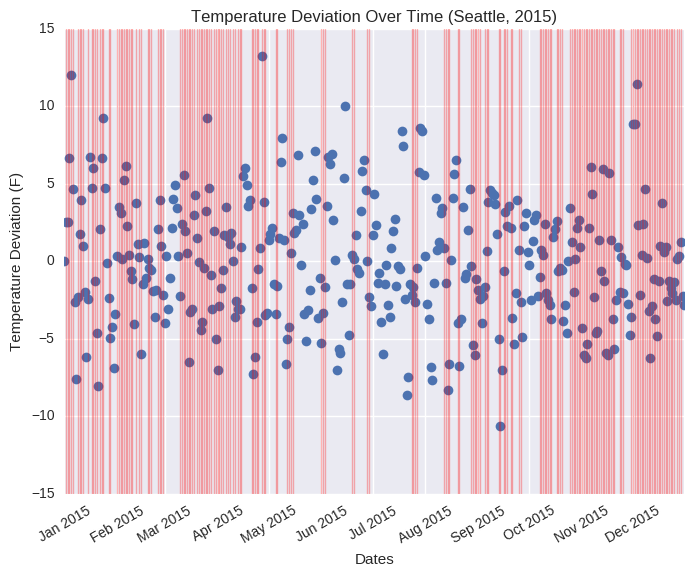

In [12]:
plot_date(seatac_2015.index.astype(datetime), seatac_2015.DEVFromAvg)

# Plots a red line on each date there is a precipitation event
for d in seatac_2015.index:
    if seatac_2015.ix[d].BOOLPrecip == True:
        plt.axvline(d, color='red', alpha=0.3, linewidth=1)

plt.xticks(rotation=30)
plt.xlabel('Dates')
plt.ylabel('Temperature Deviation (F)')
plt.title('Temperature Deviation Over Time (Seattle, 2015)')
plt.show()

In [13]:
formula = 'seatac_2015.BOOLPrecipNum ~ seatac_2015.DEVFromAvg'
model = smf.ols(formula, data=seatac_2015)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     seatac_2015.BOOLPrecipNum   R-squared:                       0.007
Model:                                   OLS   Adj. R-squared:                  0.004
Method:                        Least Squares   F-statistic:                     2.452
Date:                       Wed, 22 Mar 2017   Prob (F-statistic):              0.118
Time:                               14:57:34   Log-Likelihood:                -263.29
No. Observations:                        365   AIC:                             530.6
Df Residuals:                            363   BIC:                             538.4
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                  0.5234      0.026     20.032      0.000         0.472     0.575
seatac_2015.DEVFromAvg    -0.0102      0.007     -1.566      0.118        -0.023     0.003
==============================================================================
Omnibus:                        0.542   Durbin-Watson:                   0.867
Prob(Omnibus):                  0.763   Jarque-Bera (JB):               59.185
Skew:                          -0.093   Prob(JB):                     1.41e-13
Kurtosis:                       1.036   Cond. No.                         3.99
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""